# Table of Contents


In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
from tqdm.notebook import tqdm

import numpy as onp
import matplotlib.pyplot as plt # visualization

import jax
from jax import ops
import jax.numpy as np
from jax import jit, grad, value_and_grad, random
from jax import lax
from jax.random import split
from jax.tree_util import tree_multimap
from jax import vmap
from jax.tree_util import Partial as partial

from jax.experimental import optix
from jax.experimental import optimizers
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers

In [3]:
rng = random.PRNGKey(0)
rng

/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([0, 0], dtype=uint32)

In [34]:
def sample_tasks(rng, outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    rng, rngA, rngP = split(rng, 3)
    As = random.uniform(rngA, shape=(outer_batch_size,), minval=0.1, maxval=5.0)
    phases = random.uniform(rngP, shape=(outer_batch_size,), minval=0, maxval=np.pi)
    
    def get_batch(rng):
        xs = np.empty((outer_batch_size, inner_batch_size, 1))
        ys = np.empty((outer_batch_size, inner_batch_size, 1))
        rngs = split(rng, outer_batch_size)
        for i, (A, phase, rng) in enumerate(zip(As, phases, rngs)):
            x = random.uniform(rng, shape=(inner_batch_size, 1), minval=-5., maxval=5., )
            y = A * np.sin(x + phase)
            xs = ops.index_update(xs, i, x)
            ys = ops.index_update(ys, i, y)
        return xs, ys
    rng2, rng3 = split(rng, 2)
    x1, y1 = get_batch(rng2)
    x2, y2 = get_batch(rng3)
    return x1, y1, x2, y2, As, phases

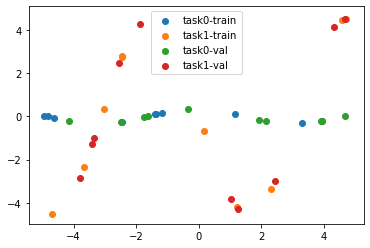

In [91]:
rng, rng_sample = split(rng, 2)
x1, y1, x2, y2, As, phases = sample_tasks(rng, 2, 10)

for i in range(x1.shape[0]):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(x1.shape[0]):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [14]:
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1),
)

def make_net(rng, in_shape=(-1, 1)):
    rng, rng_net = split(rng, 2)
    return net_init(rng_net, in_shape)

def mse_loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions) ** 2)

# Train vanilla

In [15]:
xrange_inputs = np.linspace(-5, 5, 100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)

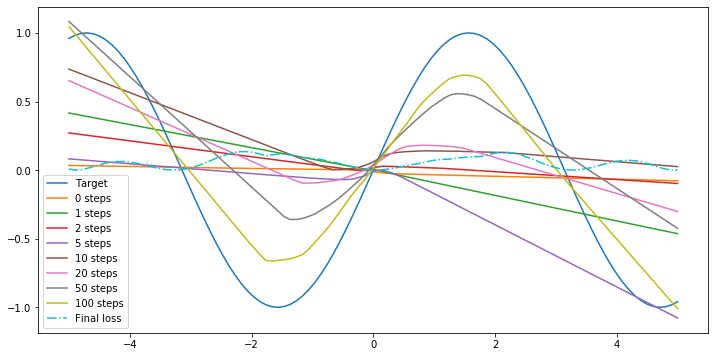

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, targets, label="Target")

out_shape, net_params = make_net(rng)
opt_init, opt_update, get_params = optimizers.sgd(1e-1)
opt_state = opt_init(net_params)

ax.plot(xrange_inputs, net_apply(net_params, xrange_inputs), label="0 steps")
plot_steps = [1, 2, 5, 10, 20, 50, 100]
for i in range(1, 101):
    loss, grads = value_and_grad(mse_loss)(net_params, xrange_inputs, targets)
    opt_state = opt_update(i - 1, grads, opt_state)
    net_params = get_params(opt_state)
    
    if i in plot_steps:
        preds = net_apply(net_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % i)

pointwise_loss = (preds - targets) ** 2
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Final loss")
ax.legend()

# MAML Methods

In [138]:
inner_opt = optix.sgd(1e-3)

@jit
def get_updates(params, x, y, opt_state):
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    return inner_opt.update(grads, opt_state, params), loss

@jit
def single_update(params, x, y, opt_state=None):
    (updates, new_state), loss = get_updates(params, x, y, opt_state)
    params = optix.apply_updates(params, updates)
    return (params, new_state), loss

def k_updates(params, x, y, k, opt_state, opt_update):
    opt_state = inner_opt.init(params)
    loss_history = []
    for _ in range(k):
        (params, opt_state), pre_step_loss = single_update(params, x, y, opt_state)
        loss_history.append(loss)
    return (params, opt_state), loss_history

def jittable_k_updates(params, x, y, k, opt_state, opt_update):
    loss_history = np.zeros(k + 1)
    initial_loss = mse_loss(params, x, y)
    loss_history = ops.index_update(loss_history, 0, initial_loss)
    for i in range(k):
        grads = grad(mse_loss)(params, x, y)
        updates, opt_state = opt_update(grads, opt_state, params)
        params = optix.apply_updates(params, updates)
        loss = mse_loss(params, x, y)
        loss_history = ops.index_update(loss_history, i + 1, loss)
    return (params, opt_state), loss_history

def jittable_maml_loss(params, x_in, y_in, x_out, y_out, k, inner_opt):
    opt_state = inner_opt.init(params)
    (params, _), inner_loss = jittable_k_updates(params, x_in, y_in, k, opt_state, inner_opt.update)
    return mse_loss(params, x_out, y_out), inner_loss

def jittable_outer_loss_and_grads(params, x_in, y_in, x_out, y_out, k):
    return value_and_grad(jittable_maml_loss, has_aux=True)(params, x_in, y_in, x_out, y_out, k)

# Single batch

In [139]:
## 
inner_opt = optix.sgd(1e-3)
outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = make_net(rng)
outer_opt_state = outer_opt_init(net_params)

num_inner_steps = 1

@jit
def maml_loss(params, x_in, y_in, x_out, y_out):
    return jittable_maml_loss(
        params, x_in, y_in, x_out, y_out, num_inner_steps, inner_opt,
    )

jit_sample_tasks = jit(sample_tasks, static_argnums=(1, 2))
@jit
# def step(i, opt_state, x1, y1, x2, y2):
def step(i, opt_state, rng_task):
    x1, y1, x2, y2, _, _ = jit_sample_tasks(rng_task, 1, 10)
    p = outer_get_params(opt_state)
    (outer_loss, inner_loss), outer_grads = value_and_grad(maml_loss, has_aux=True)(
        p, x1[0], y1[0], x2[0], y2[0],
    )
    opt_state = outer_opt_update(i, outer_grads, opt_state)
    net_params = outer_get_params(opt_state)
    final_loss = mse_loss(net_params, x2[0], y2[0])
    
    return opt_state, final_loss, inner_loss

num_outer_steps = 10000
pbar = tqdm(range(num_outer_steps))
np_maml_loss = []
for i in pbar:
    rng, rng_task = split(rng, 2)
    # x1, y1, x2, y2 = sample_tasks(1, 50, rng_task)
    # outer_opt_state, final_loss, inner_loss = step(i, outer_opt_state, x1, y1, x2, y2)
    outer_opt_state, final_loss, inner_loss = step(i, outer_opt_state, rng_task)

    pbar.set_postfix(
        outer_outer=final_loss, inner_loss=inner_loss[-1],
    )
    np_maml_loss.append(final_loss)
    
single_batch_params = outer_get_params(outer_opt_state)

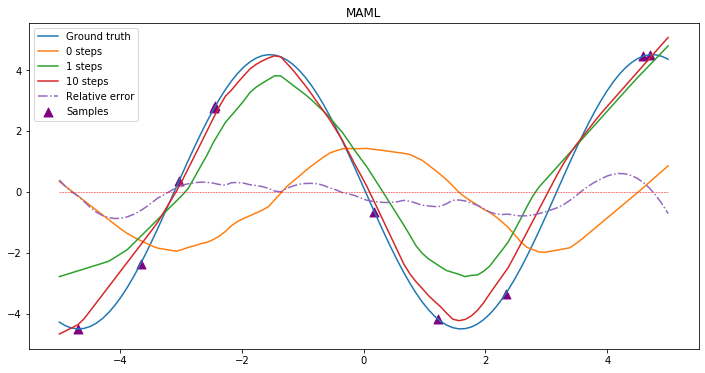

In [140]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, np.sin(xrange_inputs + phases[1]) * As[1], label="Ground truth")
ax.scatter(x1[1], y1[1], marker="^", label="Samples", color="purple", s=80)

new_params = single_batch_params
ax.plot(xrange_inputs, net_apply(new_params, xrange_inputs), label="0 steps")
inner_opt = optix.sgd(1e-3)
inner_opt_state = inner_opt.init(new_params)
for i in range(0, 10):
    # inner_opt_state = inner_opt.init(new_params)
    (new_params, inner_opt_state), loss = jittable_k_updates(
        new_params, x1[1], y1[1], k=1, opt_state=inner_opt_state, opt_update=inner_opt.update,
    )

    if (i + 1) in [1, 10]:
        preds = net_apply(new_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % (i + 1))

pointwise_loss = (np.sin(xrange_inputs + phases[1]) * As[1] - preds)
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.plot(xrange_inputs, np.zeros(len(xrange_inputs)), color="red", linestyle='--', linewidth=0.5)

ax.legend()
ax.set_title("MAML");

# Multi batch

In [144]:
inner_opt = optix.sgd(1e-3)
outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = make_net(rng)
outer_opt_state = outer_opt_init(net_params)

num_inner_steps = 1
num_tasks = 25
num_samples = 10

@jit
def jit_maml_loss(params, x_in, y_in, x_out, y_out):
    return jittable_maml_loss(params, x_in, y_in, x_out, y_out, num_inner_steps, inner_opt)

@jit
def batch_outer_loss(p, x1_b, y1_b, x2_b, y2_b):
    outer_losses, inner_losses = vmap(partial(jit_maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return outer_losses.mean(), inner_losses.mean(0)

jit_sample_tasks = jit(sample_tasks, static_argnums=(1, 2))

@jit
def step(i, opt_state, rng_task):
    x1, y1, x2, y2, _, _ = jit_sample_tasks(rng_task, num_tasks, num_samples)
    p = outer_get_params(opt_state)
    (outer_loss, inner_loss), outer_grads = value_and_grad(
        batch_outer_loss, has_aux=True
    )(p, x1, y1, x2, y2)
    opt_state = outer_opt_update(i, outer_grads, opt_state)
    net_params = outer_get_params(opt_state)
    # final_loss = mse_loss(net_params, x2[0], y2[0])
    
    return opt_state, outer_loss, inner_loss

num_outer_steps = 70000
pbar = tqdm(range(num_outer_steps))
np_batched_maml_loss = []
for i in pbar:
    rng, rng_task = split(rng, 2)
    outer_opt_state, outer_loss, inner_loss = step(i, outer_opt_state, rng_task)

    pbar.set_postfix(
        outer_loss=outer_loss, inner_loss=inner_loss[-1],
    )
    np_batched_maml_loss.append(outer_loss)
    
multi_batch_params = outer_get_params(outer_opt_state)

MSE 5-shot 1 steps
0.58698726
MSE 5-shot 5 steps
0.48661923
MSE 5-shot 10 steps
0.46918568


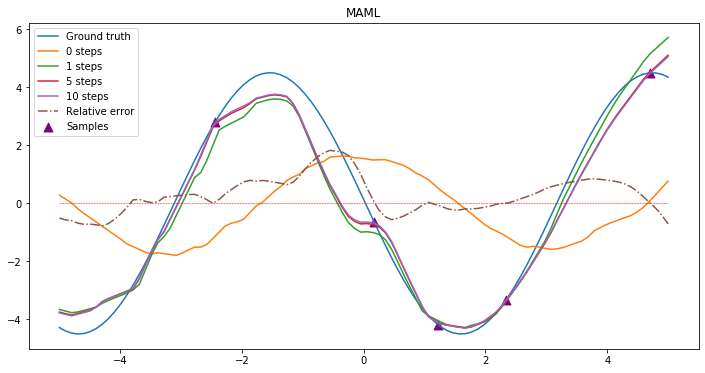

In [153]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, np.sin(xrange_inputs + phases[1]) * As[1], label="Ground truth")
ax.scatter(x1[1, :5], y1[1, :5], marker="^", label="Samples", color="purple", s=80)

new_params = multi_batch_params
ax.plot(xrange_inputs, net_apply(new_params, xrange_inputs), label="0 steps")
inner_opt = optix.sgd(1e-3)
inner_opt_state = inner_opt.init(new_params)
for i in range(0, 10):
    # inner_opt_state = inner_opt.init(new_params)
    (new_params, inner_opt_state), loss = jittable_k_updates(
        new_params, x1[1, :5], y1[1, :5], k=1, opt_state=inner_opt_state, opt_update=inner_opt.update,
    )

    if (i + 1) in [1, 5, 10]:
        preds = net_apply(new_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % (i + 1))

        pointwise_loss = (np.sin(xrange_inputs + phases[1]) * As[1] - preds)
        print("MSE 5-shot %d steps" % (i + 1))
        print((pointwise_loss ** 2).mean())
        
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.plot(xrange_inputs, np.zeros(len(xrange_inputs)), color="red", linestyle='--', linewidth=0.5)


ax.legend()
ax.set_title("MAML");

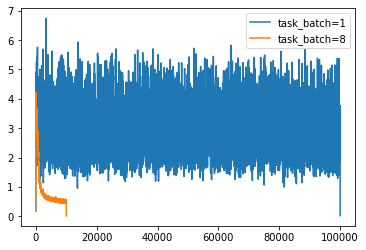

In [90]:
# Comparison of maml_loss for task batch size = 1 vs. task batch size = 8
plt.plot(onp.convolve(np_maml_loss, [.05] * 20), label='task_batch=1')
plt.plot(onp.convolve(np_batched_maml_loss, [.05]*20), label='task_batch=8')
# plt.ylim(0., 1e-1)
plt.legend()